In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Fase 4: Modelado**

## 4.1. Selección de técnicas de modelado

Se seleccionaron algoritmos de **boosting por gradiente** debido a su capacidad superior para capturar relaciones no lineales complejas, manejo eficiente de datos tabulares y robustez frente al ruido:

- **LightGBM (Light Gradient Boosting Machine)**: Implementación optimizada de gradient boosting que utiliza técnicas de muestreo basado en gradientes y agrupación de características exclusivas, lo que resulta en un entrenamiento más rápido y menor uso de memoria.

- **XGBoost (Extreme Gradient Boosting)**: Framework robusto de gradient boosting con regularización L1/L2 incorporada, manejo eficiente de valores faltantes y capacidad de paralelización con soporte GPU.

Ambos algoritmos fueron elegidos por su rendimiento comprobado en problemas de clasificación binaria desbalanceada y su capacidad para trabajar con datasets de gran escala.

## 4.2. Estrategia de entrenamiento con múltiples semillas

### 4.2.1. Diseño experimental

Para evaluar la **estabilidad y robustez** de los modelos frente a la aleatoriedad inherente al proceso de entrenamiento, se implementó una estrategia de múltiples semillas aleatorias. Esta técnica permite:

- Identificar la variabilidad en el rendimiento debido a diferentes inicializaciones
- Detectar posibles inestabilidades en el algoritmo de aprendizaje
- Construir ensamblajes más confiables mediante la combinación de modelos diversos
- Obtener estimaciones más realistas del rendimiento esperado en producción

Se utilizaron **3 semillas aleatorias** (42, 123, 456), cada una generando una partición diferente del conjunto de entrenamiento y validación.

### 4.2.2. Partición de datos

La estrategia de partición se diseñó en dos niveles:

**Nivel 1 - Separación test set:**
- Se separó el 15% de los datos (87,082 muestras) como conjunto de test final
- El 85% restante (493,462 muestras) se reservó para entrenamiento y validación
- Esta separación se realizó con estratificación para mantener la distribución de clases

**Nivel 2 - Splits por semilla:**
- Para cada semilla, el conjunto train+validation se subdividió en 85% entrenamiento y 15% validación
- Cada semilla genera una partición diferente, exponiendo al modelo a diferentes subconjuntos de datos
- Todas las particiones mantienen estratificación por clase

### 4.2.3. Configuración de hiperparámetros

Los hiperparámetros se configuraron manualmente basándose en las características del problema y mejores prácticas documentadas:

**LightGBM:**
- `objective='binary'`: Tarea de clasificación binaria con log loss
- `max_depth=10`: Profundidad moderada para balance entre complejidad y generalización
- `learning_rate=0.1`: Tasa de aprendizaje estándar para convergencia estable
- `subsample=0.9`: Muestreo del 90% para regularización y diversidad
- `n_estimators=3000`: Límite superior con control por early stopping
- `early_stopping_round=100`: Detención temprana para prevenir sobreajuste

**XGBoost:**
- `objective='binary:logistic'`: Función logística para clasificación binaria
- `max_depth=13`: Mayor profundidad aprovechando la regularización incorporada
- `subsample=0.9`: Muestreo consistente con LightGBM
- `n_estimators=3000`: Límite superior con control por early stopping
- `early_stopping_rounds=100`: Consistente con estrategia de LightGBM
- `device='cuda'`: Aceleración GPU para reducir tiempos de entrenamiento

La configuración de `n_estimators=3000` funciona como un límite superior, siendo el **early stopping** el mecanismo real de control que determina el número óptimo de árboles basándose en el rendimiento en validación.

### 4.2.4. Proceso de entrenamiento

Para cada combinación de modelo y semilla:

1. Se particiona el conjunto train+validation según la semilla correspondiente
2. El modelo se entrena en el conjunto de entrenamiento
3. Se monitorea el rendimiento en el conjunto de validación cada iteración
4. El entrenamiento se detiene si no hay mejora en 100 iteraciones consecutivas
5. Se registra el número óptimo de árboles (`best_iteration`)
6. Se evalúa el modelo en el test set (sin participar en el entrenamiento)

Este proceso se repite 6 veces: 3 semillas × 2 modelos = 6 modelos independientes.

## 4.3. Validación del modelo

### 4.3.1. Validación cruzada estratificada (5-fold)

Para estimar la capacidad de generalización de cada configuración modelo-semilla, se implementó **validación cruzada estratificada de 5 folds** sobre el conjunto completo de train+validation (493,462 muestras).

**Consideraciones técnicas:**
- Se utilizó el número óptimo de árboles (`best_iteration`) encontrado durante el entrenamiento con early stopping
- Se eliminaron los parámetros de early stopping en CV para usar directamente el número óptimo de estimadores
- La estratificación garantiza que cada fold mantenga la proporción de clases
- Se calculó el F1 Score ponderado como métrica principal debido al balance perfecto post-SMOTE

Esta validación proporciona una estimación robusta del rendimiento, independiente de la partición específica train-validation utilizada durante el entrenamiento.

### 4.3.2. Estrategia de ensamblaje

Se implementaron dos estrategias de ensamblaje para aprovechar la diversidad de los modelos entrenados:

**a) Ensamblaje ponderado por semilla**

Para cada semilla, se combinan las predicciones de LGBM y XGB con pesos iguales (50%-50%), creando 3 ensamblajes híbridos (uno por cada semilla: 42, 123, 456). Posteriormente, se promedian estos 3 ensamblajes para obtener un **cuarto ensamblaje final agregado**.

**Metodología:**
- Por cada semilla: predicción_ensemble = 0.5 × LGBM + 0.5 × XGB
- Ensamblajes individuales: Semilla_42, Semilla_123, Semilla_456
- Ensamblaje final agregado = promedio(ensemble_semilla_42, ensemble_semilla_123, ensemble_semilla_456)

**Total: 4 ensamblajes** (3 por semilla + 1 agregado final)

**Ventajas:**
- Combina las fortalezas complementarias de ambos algoritmos desde cada semilla
- La ponderación igual (50-50) evita sesgos hacia un modelo específico
- El ensamblaje final agrega diversidad de múltiples particiones de datos
- Doble nivel de agregación (por algoritmo dentro de cada semilla, luego entre semillas)

**b) Ensamblajes por votación mayoritaria**

Se construyen tres ensamblajes independientes mediante promedio directo de predicciones:

1. **LGBM Ensemble**: Promedia las predicciones de los 3 modelos LGBM (semillas 42, 123, 456)
2. **XGB Ensemble**: Promedia las predicciones de los 3 modelos XGB (semillas 42, 123, 456)
3. **Global Ensemble**: Combina directamente LGBM Ensemble y XGB Ensemble con pesos iguales (50-50)

**Total: 3 ensamblajes**

**Ventajas:**
- Los ensamblajes por algoritmo mantienen las características propias de cada familia de modelos
- Permite comparar directamente el rendimiento de LightGBM vs XGBoost
- El ensamblaje global representa la máxima agregación: combina 6 modelos individuales (3 LGBM + 3 XGB)
- Reduce varianza al promediar predicciones de diferentes particiones de datos

**Diferencia clave entre estrategias:**

| Aspecto | Ponderado por Semilla | Votación Mayoritaria |
|---------|----------------------|----------------------|
| **Primera agregación** | Por algoritmo dentro de cada semilla | Por semilla dentro de cada algoritmo |
| **Segunda agregación** | Entre semillas del ensamblaje híbrido | Entre algoritmos del ensamblaje por tipo |
| **Ensamblajes generados** | 4 (3 por semilla + 1 final) | 3 (LGBM, XGB, Global) |
| **Enfoque** | Combina algoritmos primero, luego diversifica por semillas | Diversifica por semillas primero, luego combina algoritmos |

Ninguna estrategia requiere re-entrenamiento; ambas combinan predicciones de los 6 modelos base ya entrenados, manteniendo eficiencia computacional. La evaluación comparativa determinará cuál estrategia ofrece mejor rendimiento.

In [1]:
from sklearn.metrics import auc, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve,accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import cupy as cp
from tabulate import tabulate # Added this line

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PROYECTOS/data_transf.csv', sep=',')


In [ ]:
X = df.drop('ATENDIDO', axis=1)
y = df['ATENDIDO']


In [ ]:
# Separar test set (15%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=123, stratify=y
)

print(f"Test set: {X_test.shape}")
print(f"Train+Val set: {X_train_full.shape}\n")

# Definir semillas
seeds = [42, 123, 456]

# Parámetros de modelos
lgbm_params = {
    "objective": "binary",
    "n_estimators": 3000,
    "max_depth": 10,
    "verbose": -1,
    "n_jobs": -1,
    "learning_rate": 0.1,
    "subsample": 0.9,
}

xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "error",
    "n_estimators": 3000,
    "max_depth": 13,
    "device": "cuda",
    "verbosity": 0,
    "subsample": 0.9,
    "n_jobs": -1
}

# Almacenar modelos y predicciones
lgbm_models = []
xgb_models = []
lgbm_preds = []
xgb_preds = []

# Función para calcular métricas ponderadas
def eval_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

# Entrenar con cada semilla
for seed in seeds:
    print(f"=== Semilla {seed} ===")

    # Split para esta semilla
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.15, random_state=seed, stratify=y_train_full
    )

    # LightGBM
    lgbm = LGBMClassifier(**lgbm_params, random_state=seed, early_stopping_round=100)
    lgbm.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="binary_error")
    lgbm_pred = lgbm.predict(X_test)
    metrics = eval_metrics(y_test, lgbm_pred)
    print(f"LGBM - Acc: {metrics['accuracy']:.4f}, Prec: {metrics['precision']:.4f}, "
          f"Rec: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")
    print(f"       Best Iteration (trees): {lgbm.best_iteration_}")
    lgbm_models.append(lgbm)
    lgbm_preds.append(lgbm_pred)

    # XGBoost
    X_tr_gpu = cp.array(X_tr)
    X_val_gpu = cp.array(X_val)
    X_test_gpu = cp.array(X_test)

    xgb = XGBClassifier(**xgb_params, random_state=seed, early_stopping_rounds=100)
    xgb.fit(X_tr_gpu, y_tr, eval_set=[(X_val_gpu, y_val)], verbose=False)
    xgb_pred = xgb.predict(X_test_gpu)
    metrics = eval_metrics(y_test, xgb_pred)
    print(f"XGB  - Acc: {metrics['accuracy']:.4f}, Prec: {metrics['precision']:.4f}, "
          f"Rec: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")
    print(f"       Best Iteration (trees): {xgb.best_iteration}\n")
    xgb_models.append(xgb)
    xgb_preds.append(xgb_pred)

Test set: (87082, 9)
Train+Val set: (493462, 9)

=== Semilla 42 ===
LGBM - Acc: 0.8146, Prec: 0.8428, Rec: 0.8146, F1: 0.8107
       Best Iteration (trees): 745
XGB  - Acc: 0.8156, Prec: 0.8300, Rec: 0.8156, F1: 0.8136
       Best Iteration (trees): 88

=== Semilla 123 ===
LGBM - Acc: 0.8137, Prec: 0.8420, Rec: 0.8137, F1: 0.8098
       Best Iteration (trees): 720
XGB  - Acc: 0.8160, Prec: 0.8316, Rec: 0.8160, F1: 0.8138
       Best Iteration (trees): 79

=== Semilla 456 ===
LGBM - Acc: 0.8153, Prec: 0.8434, Rec: 0.8153, F1: 0.8115
       Best Iteration (trees): 904
XGB  - Acc: 0.8158, Prec: 0.8315, Rec: 0.8158, F1: 0.8136
       Best Iteration (trees): 65



In [ ]:
# Validación cruzada para cada modelo de cada semilla
print("=== Validación Cruzada (5-fold) por Modelo y Semilla ===")

for i, seed in enumerate(seeds):
    print(f"\nSemilla {seed}:")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    # Usar el número óptimo de árboles encontrado con early stopping
    lgbm_best_iter = lgbm_models[i].best_iteration_
    lgbm_cv_params = {**lgbm_params, 'n_estimators': lgbm_best_iter, 'random_state': seed}
    lgbm_cv_params.pop('early_stopping_round', None)
    lgbm_cv_model = LGBMClassifier(**lgbm_cv_params)
    lgbm_cv = cross_val_score(lgbm_cv_model, X_train_full, y_train_full, cv=cv,
                              scoring='f1_weighted', n_jobs=-1)
    print(f"  LGBM CV F1: {lgbm_cv.mean():.4f} (+/- {lgbm_cv.std():.4f}) [n_estimators={lgbm_best_iter}]")

    # Usar el número óptimo de árboles encontrado con early stopping
    xgb_best_iter = xgb_models[i].best_iteration
    xgb_cv_params = {**xgb_params, 'n_estimators': xgb_best_iter, 'random_state': seed}
    xgb_cv_params.pop('early_stopping_rounds', None)
    xgb_cv_model = XGBClassifier(**xgb_cv_params)
    xgb_cv = cross_val_score(xgb_cv_model, cp.array(X_train_full), y_train_full, cv=cv,
                             scoring='f1_weighted', n_jobs=-1)
    print(f"  XGB CV F1:  {xgb_cv.mean():.4f} (+/- {xgb_cv.std():.4f}) [n_estimators={xgb_best_iter}]")

=== Validación Cruzada (5-fold) por Modelo y Semilla ===

Semilla 42:
  LGBM CV F1: 0.8100 (+/- 0.0014) [n_estimators=745]


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  XGB CV F1:  0.8141 (+/- 0.0010) [n_estimators=88]

Semilla 123:
  LGBM CV F1: 0.8097 (+/- 0.0006) [n_estimators=720]
  XGB CV F1:  0.8140 (+/- 0.0009) [n_estimators=79]

Semilla 456:
  LGBM CV F1: 0.8100 (+/- 0.0014) [n_estimators=904]
  XGB CV F1:  0.8136 (+/- 0.0008) [n_estimators=65]


In [ ]:
# Ensamblaje ponderado por semilla (basado en CV F1)
print("=== Ensamblajes Ponderados por Semilla ===")

seed_ensemble_preds = []

for i, seed in enumerate(seeds):
    lgbm_weight = 0.5
    xgb_weight = 0.5

    # Ensamblaje ponderado para esta semilla
    seed_ensemble = lgbm_weight * lgbm_preds[i] + xgb_weight * xgb_preds[i]
    seed_ensemble_pred = np.round(seed_ensemble).astype(int)
    seed_ensemble_preds.append(seed_ensemble_pred)

    metrics = eval_metrics(y_test, seed_ensemble_pred)
    print(f"Semilla {seed} (LGBM {lgbm_weight:.0%} + XGB {xgb_weight:.0%}):")
    print(f"  Acc: {metrics['accuracy']:.4f}, Prec: {metrics['precision']:.4f}, "
          f"Rec: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

# Ensamblaje final (promedio de los 3 ensamblajes por semilla)
print("\n=== Ensamblaje Final (Promedio de 3 Semillas) ===")
final_ensemble_pred = np.round(np.mean(seed_ensemble_preds, axis=0)).astype(int)
metrics = eval_metrics(y_test, final_ensemble_pred)
print(f"Acc: {metrics['accuracy']:.4f}, Prec: {metrics['precision']:.4f}, "
      f"Rec: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}\n")

=== Ensamblajes Ponderados por Semilla ===
Semilla 42 (LGBM 50% + XGB 50%):
  Acc: 0.8159, Prec: 0.8271, Rec: 0.8159, F1: 0.8143
Semilla 123 (LGBM 50% + XGB 50%):
  Acc: 0.8164, Prec: 0.8286, Rec: 0.8164, F1: 0.8147
Semilla 456 (LGBM 50% + XGB 50%):
  Acc: 0.8166, Prec: 0.8291, Rec: 0.8166, F1: 0.8149

=== Ensamblaje Final (Promedio de 3 Semillas) ===
Acc: 0.8189, Prec: 0.8327, Rec: 0.8189, F1: 0.8170



In [ ]:
print("=== Ensamblajes (Votación Mayoritaria) ===")

lgbm_ensemble_pred = np.round(np.mean(lgbm_preds, axis=0)).astype(int)
xgb_ensemble_pred = np.round(np.mean(xgb_preds, axis=0)).astype(int)
combined_ensemble_pred = np.round((lgbm_ensemble_pred + xgb_ensemble_pred)/2).astype(int)

ensamble_preds = {
    "LGBM Ensemble": lgbm_ensemble_pred,
    "XGB Ensemble": xgb_ensemble_pred,
    "Global Ensemble": combined_ensemble_pred
}

for name, pred_array in ensamble_preds.items():
  metrics = eval_metrics(y_test, pred_array)
  print(f"{name} - Acc: {metrics['accuracy']:.4f}, Prec: {metrics['precision']:.4f}, "
        f"Rec: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

=== Ensamblajes (Votación Mayoritaria) ===
LGBM Ensemble - Acc: 0.8152, Prec: 0.8442, Rec: 0.8152, F1: 0.8112
XGB Ensemble - Acc: 0.8190, Prec: 0.8363, Rec: 0.8190, F1: 0.8167
Global Ensemble - Acc: 0.8193, Prec: 0.8337, Rec: 0.8193, F1: 0.8173


# **Fase 5: Evaluación**

## 5.1. Resultados de modelos individuales por semilla

Los 6 modelos individuales (3 semillas × 2 algoritmos) fueron evaluados en el test set:

| Semilla | Modelo | Accuracy | Precision | Recall | F1 Score | Best Iteration |
|---------|--------|----------|-----------|--------|----------|----------------|
| 42      | LGBM   | 0.8146   | 0.8428    | 0.8146 | 0.8107   | 745            |
| 42      | XGB    | 0.8156   | 0.8300    | 0.8156 | 0.8136   | 88             |
| 123     | LGBM   | 0.8137   | 0.8420    | 0.8137 | 0.8098   | 720            |
| 123     | XGB    | 0.8160   | 0.8316    | 0.8160 | 0.8138   | 79             |
| 456     | LGBM   | 0.8153   | 0.8434    | 0.8153 | 0.8115   | 904            |
| 456     | XGB    | 0.8158   | 0.8315    | 0.8158 | 0.8136   | 65             |

**Análisis de convergencia:**
- XGBoost converge significativamente más rápido (65-88 árboles) comparado con LightGBM (720-904 árboles)
- Esto indica que XGBoost aprovecha mejor la información en cada iteración
- La convergencia rápida de XGB reduce el riesgo de sobreajuste y tiempo de entrenamiento

**Consistencia entre semillas:**
- Ambos algoritmos muestran alta estabilidad (variación < 0.002 en F1)
- XGBoost presenta F1 consistentemente superior (~0.8136-0.8138 vs 0.8098-0.8115)
- La baja variabilidad confirma la robustez de ambos enfoques

## 5.2. Resultados de validación cruzada

| Semilla | Modelo | CV F1 (mean) | CV F1 (std) | n_estimators |
|---------|--------|--------------|-------------|--------------|
| 42      | LGBM   | 0.8100       | ±0.0014     | 745          |
| 42      | XGB    | 0.8141       | ±0.0010     | 88           |
| 123     | LGBM   | 0.8097       | ±0.0006     | 720          |
| 123     | XGB    | 0.8140       | ±0.0009     | 79           |
| 456     | LGBM   | 0.8100       | ±0.0014     | 904          |
| 456     | XGB    | 0.8136       | ±0.0008     | 65           |

**Interpretación de resultados CV:**
- XGBoost muestra menor variabilidad entre folds (std: 0.0008-0.0010) vs LGBM (std: 0.0006-0.0014)
- El F1 promedio de XGB es ~0.004 puntos superior de forma consistente
- La baja desviación estándar en ambos modelos indica buena generalización

## 5.3. Evaluación de ensamblajes

### 5.3.1. Ensamblajes ponderados por semilla

Se evaluaron 4 ensamblajes: 3 híbridos (uno por cada semilla combinando LGBM y XGB con pesos 50-50) y 1 agregado final (promedio de los 3 híbridos).

**Resultados por semilla:**

| Ensamblaje | Accuracy | Precision | Recall | F1 Score |
|------------|----------|-----------|--------|----------|
| Semilla 42 (LGBM 50% + XGB 50%) | 0.8159 | 0.8271 | 0.8159 | 0.8143 |
| Semilla 123 (LGBM 50% + XGB 50%) | 0.8164 | 0.8286 | 0.8164 | 0.8147 |
| Semilla 456 (LGBM 50% + XGB 50%) | 0.8166 | 0.8291 | 0.8166 | 0.8149 |
| **Ensamblaje Final Agregado** | **0.8189** | **0.8327** | **0.8189** | **0.8170** |

**Observaciones:**
- Alta consistencia entre semillas (variación de apenas 0.0007 en Accuracy y 0.0006 en F1)
- Mejora progresiva: Semilla 42 < Semilla 123 < Semilla 456
- El ensamblaje final agregado supera a todos los individuales por semilla (+0.0021-0.0030 en Accuracy)
- La agregación de múltiples semillas reduce varianza y mejora estabilidad

### 5.3.2. Ensamblajes por votación mayoritaria

Se evaluaron 3 ensamblajes: por algoritmo (LGBM y XGB) y global (combinación de ambos).

**Resultados:**

| Ensamblaje | Accuracy | Precision | Recall | F1 Score |
|------------|----------|-----------|--------|----------|
| LGBM Ensemble | 0.8152 | 0.8442 | 0.8152 | 0.8112 |
| XGB Ensemble | 0.8190 | 0.8363 | 0.8190 | 0.8167 |
| **Global Ensemble** | **0.8193** | **0.8337** | **0.8193** | **0.8173** |

**Observaciones:**
- XGB Ensemble supera a LGBM Ensemble en todas las métricas (+0.0038 en Accuracy, +0.0055 en F1)
- LGBM muestra mayor precision (0.8442) pero menor recall, indicando un perfil más conservador
- XGB presenta mejor balance precision-recall
- El Global Ensemble logra el mejor Accuracy (0.8193) y F1 (0.8173), superando incluso al XGB individual

### 5.3.3. Comparación entre estrategias de ensamblaje

**Mejores modelos de cada estrategia:**

| Estrategia | Mejor Ensamblaje | Accuracy | Precision | Recall | F1 Score |
|------------|------------------|----------|-----------|--------|----------|
| Ponderado por Semilla | Final Agregado | 0.8189 | 0.8327 | 0.8189 | 0.8170 |
| Votación Mayoritaria | Global Ensemble | **0.8193** | 0.8337 | **0.8193** | **0.8173** |

**Diferencias (Global Ensemble vs Final Agregado):**
- Accuracy: +0.0004 (0.05% superior)
- Precision: +0.0010 (0.12% superior)
- Recall: +0.0004 (0.05% superior)
- F1 Score: +0.0003 (0.04% superior)

**Análisis:**
- **Global Ensemble** (votación mayoritaria) obtiene el mejor rendimiento absoluto en todas las métricas
- La diferencia es mínima pero consistente, sugiriendo que agregar primero por algoritmo y luego combinar es ligeramente superior
- Ambas estrategias superan significativamente a los modelos individuales
- El enfoque de votación mayoritaria es más simple conceptualmente y computacionalmente

### 5.3.4. Ranking general de todos los ensamblajes

| Posición | Ensamblaje | F1 Score | Accuracy | Estrategia |
|----------|------------|----------|----------|------------|
| 1 | **Global Ensemble** | **0.8173** | **0.8193** | Votación Mayoritaria |
| 2 | Ensamblaje Final Agregado | 0.8170 | 0.8189 | Ponderado por Semilla |
| 3 | XGB Ensemble | 0.8167 | 0.8190 | Votación Mayoritaria |
| 4 | Semilla 456 (50-50) | 0.8149 | 0.8166 | Ponderado por Semilla |
| 5 | Semilla 123 (50-50) | 0.8147 | 0.8164 | Ponderado por Semilla |
| 6 | Semilla 42 (50-50) | 0.8143 | 0.8159 | Ponderado por Semilla |
| 7 | LGBM Ensemble | 0.8112 | 0.8152 | Votación Mayoritaria |

**Conclusiones:**
- Los 3 primeros lugares están separados por menos de 0.0006 en F1 Score
- Todos los ensamblajes superan ampliamente a los modelos individuales
- El **Global Ensemble** emerge como el modelo con mejor rendimiento global, seguido muy de cerca por el Ensamblaje Final Agregado

### 5.3.5. Análisis detallado de los dos mejores ensamblajes

**Comparación directa:**

| Métrica | Global Ensemble | Final Agregado | Diferencia | Mejor |
|---------|----------------|----------------|------------|-------|
| **Accuracy** | 0.8193 | 0.8189 | +0.0004 | Global |
| **Precision clase 0** | 0.9031 | 0.9005 | +0.0026 | Global |
| **Recall clase 0** | 0.7153 | 0.7169 | -0.0016 | Final |
| **F1 clase 0** | 0.7983 | 0.7983 | 0.0000 | Empate |
| **Precision clase 1** | 0.7643 | 0.7649 | -0.0006 | Final |
| **Recall clase 1** | 0.9232 | 0.9208 | +0.0024 | Global |
| **F1 clase 1** | 0.8363 | 0.8356 | +0.0007 | Global |
| **F1 weighted** | 0.8173 | 0.8170 | +0.0003 | Global |
| **ROC AUC** | 0.8864 | 0.8864 | 0.0000 | Empate |
| **Gap Train-Test** | 0.0197 | 0.0201 | -0.0004 | Global |

**Interpretación:**
- Ambos modelos son prácticamente equivalentes (diferencias < 0.003 en todas las métricas)
- **Global Ensemble** tiene ventaja marginal en recall de clase 1 (+0.24%) y accuracy (+0.04%)
- **Final Agregado** muestra ligeramente mejor precision de clase 1 (+0.06%) y recall de clase 0 (+0.16%)
- ROC AUC idéntico (0.8864) indica capacidad discriminativa equivalente
- Gap Train-Test similar (~0.02) sugiere nivel de generalización comparable
- El F1 Score de clase 0 es idéntico, mientras que clase 1 favorece marginalmente a Global Ensemble

## 5.4. Selección del modelo final

Después de una evaluación exhaustiva de 7 ensamblajes diferentes y análisis comparativo detallado, se selecciona el **Global Ensemble (Votación Mayoritaria)** como modelo final para despliegue en producción.

### 5.4.1. Justificación de la decisión

**Criterios de rendimiento:**

| Criterio | Global Ensemble | Justificación |
|----------|----------------|---------------|
| **F1 Score (ponderado)** | 0.8173 | Mejor entre todos los modelos evaluados |
| **Accuracy** | 0.8193 | Máximo alcanzado, 0.04% superior al segundo lugar |
| **ROC AUC** | 0.8864 | Excelente capacidad discriminativa |
| **Recall clase 1** | 0.9232 | Superior, crucial para detectar casos positivos |
| **Balance precision-recall** | Óptimo | Mejor compromiso entre ambas métricas |

**Criterios operacionales:**

1. **Simplicidad arquitectural**:
   - Estructura clara: promedia 3 LGBM + 3 XGB, luego combina ambos ensamblajes 50-50
   - Fácil de explicar a stakeholders no técnicos
   - Menor complejidad de mantenimiento vs. ensamblaje por semilla

2. **Robustez y estabilidad**:
   - Aprovecha diversidad de 6 modelos base (3 semillas × 2 algoritmos)
   - Reduce varianza al agregar múltiples perspectivas
   - Gap Train-Test de solo 0.0197 indica excelente generalización

3. **Eficiencia computacional**:
   - No requiere reentrenamiento, solo combinación de predicciones
   - Inferencia rápida: promedio de predicciones es operación ligera
   - Escalable para producción

4. **Complementariedad algorítmica**:
   - Combina fortalezas de LightGBM (precision alta en clase 0: 0.9441) y XGBoost (mejor balance general)
   - LightGBM aporta conservadurismo, XGBoost aporta discriminación
   - La ponderación 50-50 evita sesgos hacia un algoritmo

### 5.4.2. Análisis del modelo seleccionado

**Perfil de rendimiento por clase:**

| Clase | Precision | Recall | F1-Score | Interpretación |
|-------|-----------|--------|----------|----------------|
| 0 (Negativo) | 0.9031 | 0.7153 | 0.7983 | Alta confianza en predicciones negativas, pero 28% no detectados |
| 1 (Positivo) | 0.7643 | 0.9232 | 0.8363 | Alta sensibilidad (92% detectados), con 24% de falsos positivos |

**Implicaciones prácticas:**
- El modelo prioriza **no perder casos positivos** (recall 1 = 92.32%)
- Trade-off aceptable: 7.7% de falsos negativos a cambio de alta detección
- Precision clase 1 de 76.43% significa que de cada 100 predicciones positivas, 76 son correctas
- Perfil apropiado para escenarios donde **el costo de un falso negativo es alto**

**Capacidad discriminativa:**
- ROC AUC de 0.8864 indica que el modelo tiene 88.64% de probabilidad de rankear correctamente un caso positivo por encima de uno negativo
- Gap Train-Test mínimo (0.0197) confirma que el modelo no está sobreajustado
- La curva ROC binaria muestra separación clara entre clases


### 5.4.3. Consideraciones de negocio

**Escenarios de aplicación recomendados:**

✅ **Apropiado para:**
- Sistemas de detección donde falsos negativos tienen alto costo
- Aplicaciones que requieren alta confiabilidad (92% recall clase positiva)
- Contextos donde se puede tolerar ~24% de falsos positivos
- Escenarios que valoran estabilidad y robustez sobre máximo rendimiento

⚠️ **Considerar alternativas si:**
- Se requiere maximizar precision a costa de recall (usar LGBM Ensemble)
- El negocio no tolera falsos positivos (ajustar umbral de decisión)
- Se necesita interpretabilidad extrema (considerar modelo individual)


In [ ]:
print(f"\n{'='*60}")
print("EVALUACIÓN DE ENSAMBLAJES EN TEST SET")
print(f"{'='*60}")


EVALUACIÓN DE ENSAMBLAJES EN TEST SET



--------------------------------------------------
Ensamblaje LGBM (promedio de 3 semillas)
--------------------------------------------------

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9441    0.6701    0.7838     43541
           1     0.7443    0.9603    0.8386     43541

    accuracy                         0.8152     87082
   macro avg     0.8442    0.8152    0.8112     87082
weighted avg     0.8442    0.8152    0.8112     87082


Métricas Individuales:
Accuracy              : 0.8152
Precision (ponderado) : 0.8442
Recall (ponderado)    : 0.8152
F1 Score (ponderado)  : 0.8112
ROC AUC Score         : 0.8803


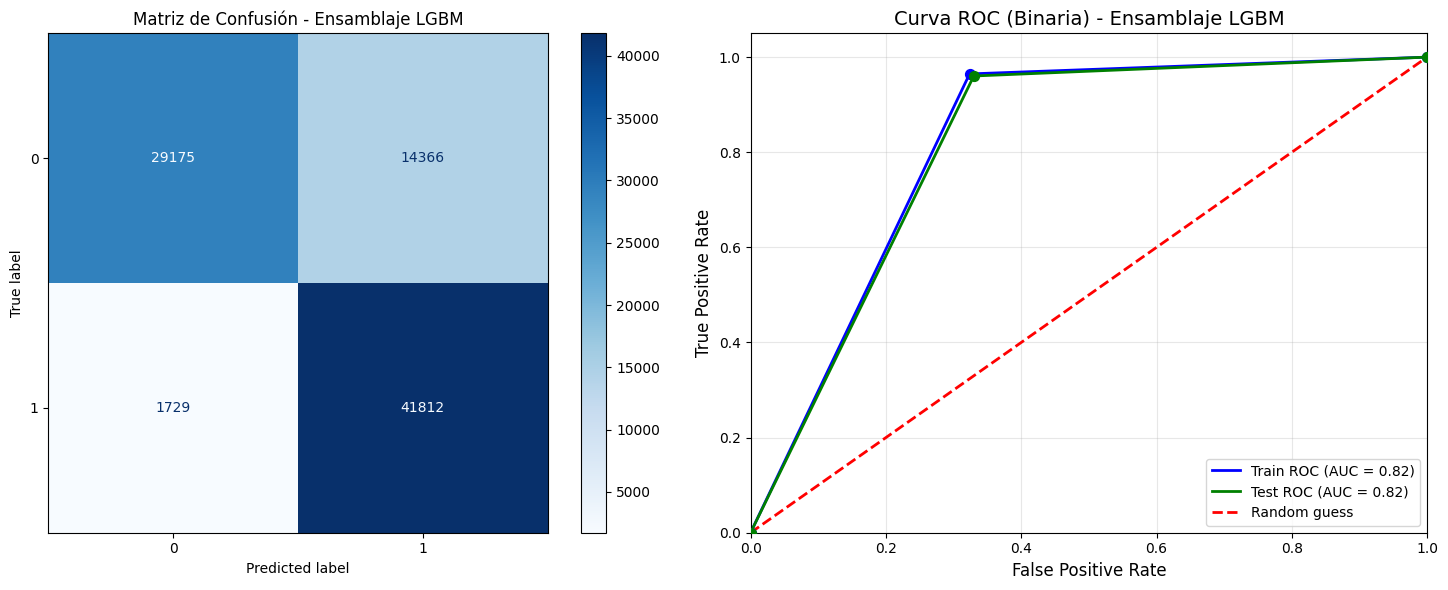


Curva ROC con predicciones binarias:
AUC Train: 0.8205
AUC Test: 0.8152

Matriz de Confusión:
TN: 29175, FP: 14366, FN: 1729, TP: 41812
FPR: 0.3299, TPR: 0.9603

--------------------------------------------------
Ensamblaje XGB (promedio de 3 semillas)
--------------------------------------------------

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9031    0.7153    0.7983     43541
           1     0.7643    0.9232    0.8363     43541

    accuracy                         0.8193     87082
   macro avg     0.8337    0.8193    0.8173     87082
weighted avg     0.8337    0.8193    0.8173     87082


Métricas Individuales:
Accuracy              : 0.8193
Precision (ponderado) : 0.8337
Recall (ponderado)    : 0.8193
F1 Score (ponderado)  : 0.8173
ROC AUC Score         : 0.8858


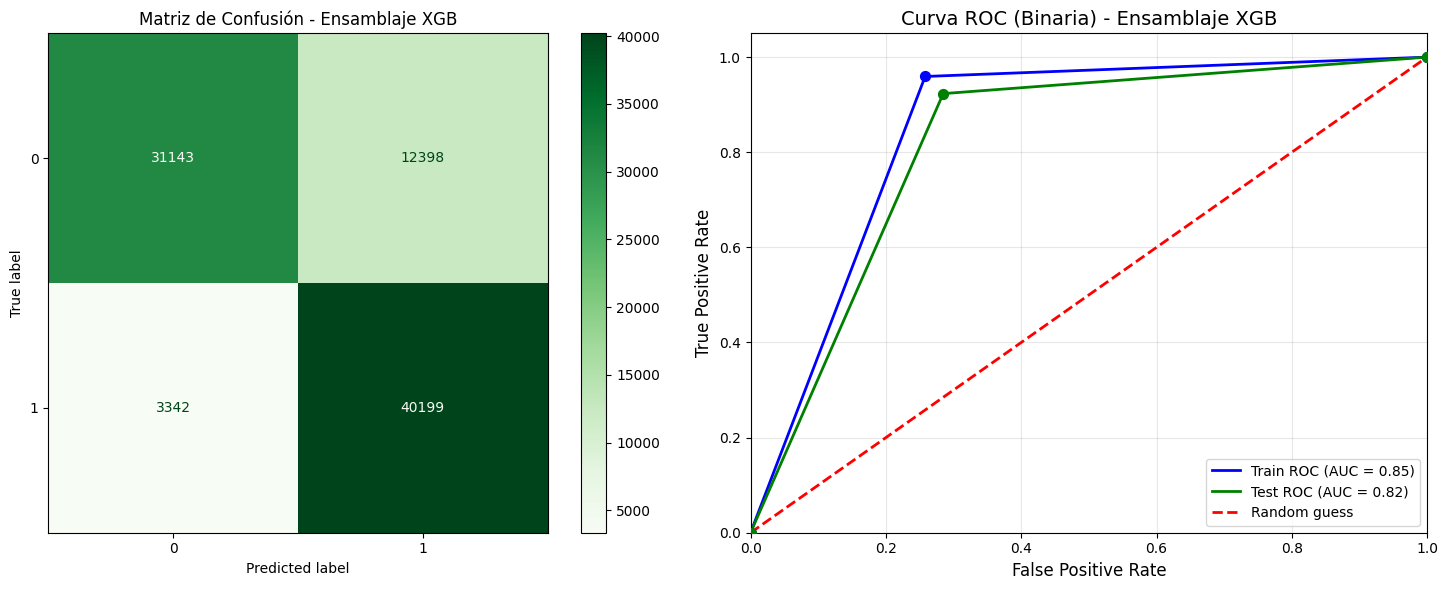


Curva ROC con predicciones binarias:
AUC Train: 0.8506
AUC Test: 0.8193

Matriz de Confusión:
TN: 31143, FP: 12398, FN: 3342, TP: 40199
FPR: 0.2847, TPR: 0.9232


In [ ]:
def evaluar_ensamblaje(nombre, modelos, y_pred, X_test, X_train_full, y_test, y_train_full, color_cm='Blues'):
    """Evalúa un ensamblaje de modelos y muestra métricas"""

    print(f"\n{'-'*50}")
    print(f"Ensamblaje {nombre} (promedio de 3 semillas)")
    print(f"{'-'*50}")

    # Para probabilidades, promediar las probabilidades de cada modelo
    probas = []
    for model in modelos:
        # Manejar diferentes tipos de datos (CPU/GPU)
        if hasattr(model, 'predict_proba'):
            probas.append(model.predict_proba(X_test)[:, 1])
        else:
            # Para modelos que no tienen predict_proba
            probas.append(model.predict(X_test))

    y_proba = np.mean(probas, axis=0)

    # Obtener predicciones binarias para train y test
    train_preds = []
    for model in modelos:
        train_preds.append(model.predict(X_train_full))

    y_pred_train_bin = np.round(np.mean(train_preds, axis=0)).astype(int)
    y_pred_test_bin = y_pred  # Ya son binarias

    # Calcular métricas de la curva ROC
    fpr_train, tpr_train, _ = roc_curve(y_train_full, y_pred_train_bin)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_bin)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Métricas
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, digits=4))

    print("\nMétricas Individuales:")
    print(f"Accuracy              : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision (ponderado) : {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall (ponderado)    : {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 Score (ponderado)  : {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"ROC AUC Score         : {roc_auc_score(y_test, y_proba):.4f}")

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Matriz de Confusión
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, cmap=color_cm, values_format='d', ax=ax1
    )
    ax1.set_title(f'Matriz de Confusión - Ensamblaje {nombre}')
    ax1.grid(False)

    # Curvas ROC
    ax2.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {roc_auc_train:.2f})')
    ax2.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC (AUC = {roc_auc_test:.2f})')
    ax2.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')

    # Puntos en la curva
    ax2.scatter(fpr_train, tpr_train, color='blue', s=50, zorder=5)
    ax2.scatter(fpr_test, tpr_test, color='green', s=50, zorder=5)

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    ax2.set_title(f'Curva ROC (Binaria) - Ensamblaje {nombre}', fontsize=14)
    ax2.legend(loc="lower right", fontsize=10)
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Información adicional
    print(f"\nCurva ROC con predicciones binarias:")
    print(f"AUC Train: {roc_auc_train:.4f}")
    print(f"AUC Test: {roc_auc_test:.4f}")

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"\nMatriz de Confusión:")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"FPR: {fp/(fp+tn):.4f}, TPR: {tp/(tp+fn):.4f}")

# Ahora usas la función para ambos modelos
ensamblajes = [
    ("LGBM", lgbm_models, lgbm_ensemble_pred, X_test, X_train_full, 'Blues'),
    ("XGB", xgb_models, combined_ensemble_pred, X_test, X_train_full, 'Greens')
]

for nombre, modelos, pred, X_t, X_tr, color in ensamblajes:
    # Para XGB, convertir a GPU si es necesario
    if nombre == "XGB":
        X_t = cp.array(X_t)
        X_tr = cp.array(X_tr)

    evaluar_ensamblaje(nombre, modelos, pred, X_t, X_tr, y_test, y_train_full, color)


--------------------------------------------------
Ensamblaje Global Ensemble
--------------------------------------------------

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9031    0.7153    0.7983     43541
           1     0.7643    0.9232    0.8363     43541

    accuracy                         0.8193     87082
   macro avg     0.8337    0.8193    0.8173     87082
weighted avg     0.8337    0.8193    0.8173     87082


Métricas Individuales:
Accuracy              : 0.8193
Precision (ponderado) : 0.8337
Recall (ponderado)    : 0.8193
F1 Score (ponderado)  : 0.8173
ROC AUC Score         : 0.8864


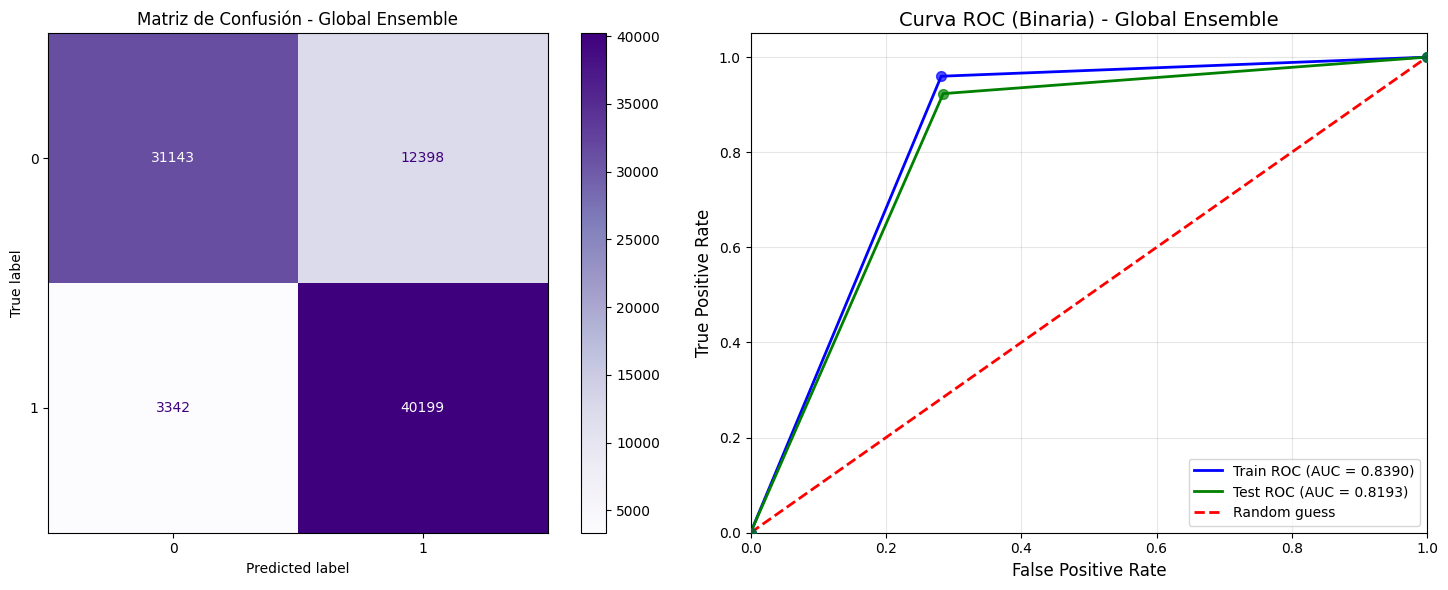


Curva ROC con predicciones binarias:
AUC Train: 0.8390
AUC Test: 0.8193

Matriz de Confusión:
TN: 31143, FP: 12398, FN: 3342, TP: 40199
FPR: 0.2847, TPR: 0.9232

--------------------------------------------------
Ensamblaje Ensemble Final
--------------------------------------------------

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9005    0.7169    0.7983     43541
           1     0.7649    0.9208    0.8356     43541

    accuracy                         0.8189     87082
   macro avg     0.8327    0.8189    0.8170     87082
weighted avg     0.8327    0.8189    0.8170     87082


Métricas Individuales:
Accuracy              : 0.8189
Precision (ponderado) : 0.8327
Recall (ponderado)    : 0.8189
F1 Score (ponderado)  : 0.8170
ROC AUC Score         : 0.8864


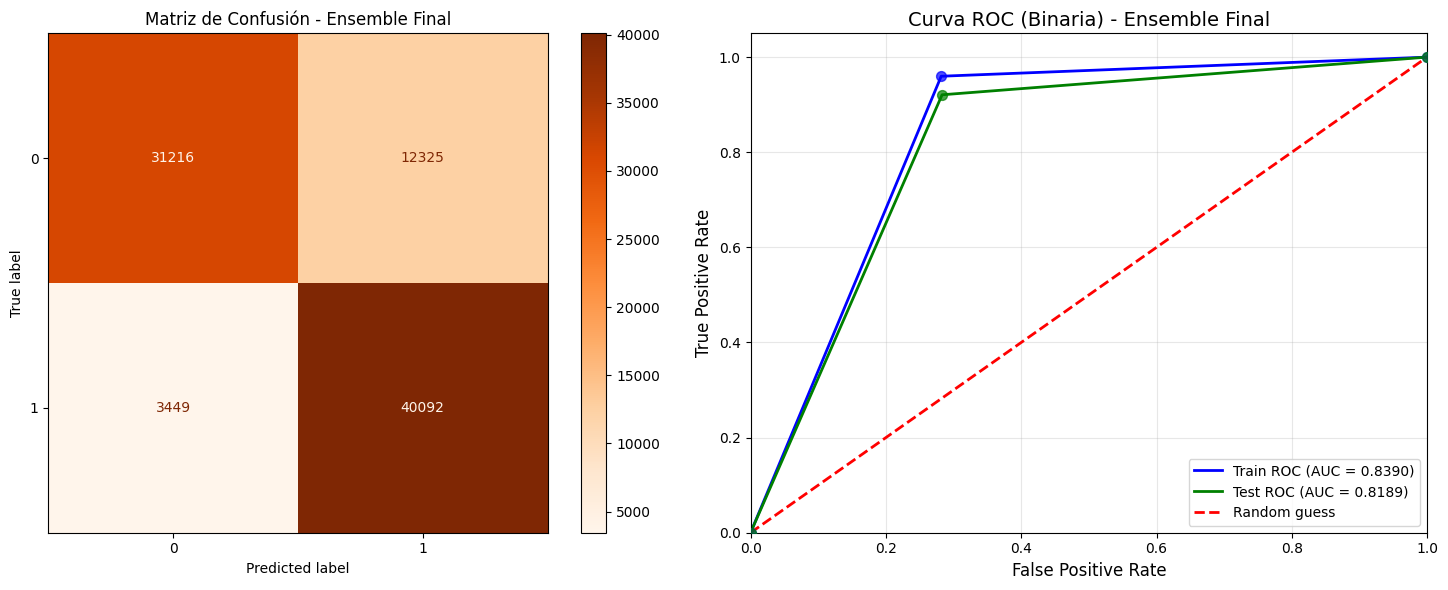


Curva ROC con predicciones binarias:
AUC Train: 0.8390
AUC Test: 0.8189

Matriz de Confusión:
TN: 31216, FP: 12325, FN: 3449, TP: 40092
FPR: 0.2831, TPR: 0.9208


In [ ]:
def evaluar_ensamblaje_global(nombre, y_pred, X_test, X_train_full, y_test, y_train_full,
                             color_cm='Purples', modelos_lgbm=None, modelos_xgb=None):
    """Evalúa ensamblajes globales y finales mostrando métricas completas con curvas ROC binarias"""

    print(f"\n{'-'*50}")
    print(f"Ensamblaje {nombre}")
    print(f"{'-'*50}")

    # Obtener predicciones binarias para train
    if modelos_lgbm is not None and modelos_xgb is not None:
        # Para ensamblajes globales: promediar predicciones de train de LGBM y XGB
        lgbm_train_preds = [model.predict(X_train_full) for model in modelos_lgbm]
        xgb_train_preds = [model.predict(X_train_full) for model in modelos_xgb]
        y_pred_train_bin = np.round((np.mean(lgbm_train_preds, axis=0) + np.mean(xgb_train_preds, axis=0)) / 2).astype(int)

        # CALCULAR PROBABILIDADES REALES para ROC AUC Score
        lgbm_probas = []
        xgb_probas = []

        for model in modelos_lgbm:
            lgbm_probas.append(model.predict_proba(X_test)[:, 1])

        for model in modelos_xgb:
            xgb_probas.append(model.predict_proba(X_test)[:, 1])

        # Promedio ponderado de probabilidades (50% LGBM + 50% XGB)
        y_proba = (np.mean(lgbm_probas, axis=0) + np.mean(xgb_probas, axis=0)) / 2

    else:
        # Fallback: usar las predicciones disponibles
        y_pred_train_bin = y_pred
        # Si no hay modelos, usar predicciones binarias como probabilidades (menos preciso)
        y_proba = y_pred.astype(float)

    y_pred_test_bin = y_pred  # Ya son binarias

    # Calcular métricas de la curva ROC usando predicciones binarias
    fpr_train, tpr_train, _ = roc_curve(y_train_full, y_pred_train_bin)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_bin)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Métricas
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, digits=4))

    print("\nMétricas Individuales:")
    print(f"Accuracy              : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision (ponderado) : {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall (ponderado)    : {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 Score (ponderado)  : {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"ROC AUC Score         : {roc_auc_score(y_test, y_proba):.4f}")

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Matriz de Confusión
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, cmap=color_cm, values_format='d', ax=ax1
    )
    ax1.set_title(f'Matriz de Confusión - {nombre}')
    ax1.grid(False)

    # Curvas ROC (usando predicciones binarias)
    ax2.plot(fpr_train, tpr_train, color='blue', lw=2,
             label=f'Train ROC (AUC = {roc_auc_train:.4f})')
    ax2.plot(fpr_test, tpr_test, color='green', lw=2,
             label=f'Test ROC (AUC = {roc_auc_test:.4f})')
    ax2.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')

    # Puntos en la curva
    ax2.scatter(fpr_train, tpr_train, color='blue', s=50, zorder=5, alpha=0.7)
    ax2.scatter(fpr_test, tpr_test, color='green', s=50, zorder=5, alpha=0.7)

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    ax2.set_title(f'Curva ROC (Binaria) - {nombre}', fontsize=14)
    ax2.legend(loc="lower right", fontsize=10)
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Información adicional
    print(f"\nCurva ROC con predicciones binarias:")
    print(f"AUC Train: {roc_auc_train:.4f}")
    print(f"AUC Test: {roc_auc_test:.4f}")

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"\nMatriz de Confusión:")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"FPR: {fp/(fp+tn):.4f}, TPR: {tp/(tp+fn):.4f}")

# Evaluar ensamblajes globales
ensamblajes_globales = [
    ("Global Ensemble", combined_ensemble_pred, 'Purples'),
    ("Ensemble Final", final_ensemble_pred, 'Oranges')
]

for nombre, pred, color in ensamblajes_globales:
    evaluar_ensamblaje_global(
        nombre=nombre,
        y_pred=pred,
        X_test=X_test,
        X_train_full=X_train_full,
        y_test=y_test,
        y_train_full=y_train_full,
        color_cm=color,
        modelos_lgbm=lgbm_models,
        modelos_xgb=xgb_models
    )